In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns

game_dat = pd.read_csv('../possibility_app/static/stim_data/HMTG_possib_stim.csv', header=0, index_col=0)

# 1. Define generative models

In [2]:

def compute_bic(n_obs, sse, n_par):
    bic = n_obs * np.log(sse / n_obs) + n_par * np.log(n_obs)
    return bic

def compute_aic(n_obs, sse, n_par):
    aic = n_obs * np.log(sse/n_obs) + 2*n_par
    return aic


def soft_max(x, tau):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(np.array(x) / tau)
    return e_x / e_x.sum(axis=0)

def gr_model(inv, mult, theta, phi):
    inv = float(inv)
    mult = float(mult)
    theta = float(theta)
    phi = float(phi)
    return 0

def ga_model(inv, mult, exp, theta, phi):
    inv = float(inv)
    mult = float(mult)
    belMult = float(4)
    exp = float(exp)
    theta = float(theta)
    phi = float(phi)

    total_amt = inv * mult
    choice_opts = np.arange(0, total_amt + 1)

    guilt = np.square(np.maximum((exp - choice_opts) / (inv * belMult), 0))

    own = total_amt - choice_opts

    utility = own - theta * guilt

    return choice_opts[np.where(utility == np.max(utility))[0][0]]

def ia_model(inv, mult, theta, phi):
    inv = float(inv)
    mult = float(mult)
    theta = float(theta)
    phi = float(phi)

    total_amt = inv * mult
    choice_opts = np.arange(0, total_amt + 1)

    own = total_amt - choice_opts
    other = 10 - inv + choice_opts

    inequity = np.square(own / (own + other) - .5)

    utility = own - theta * inequity

    return choice_opts[np.where(utility == np.max(utility))[0][0]]

def mp_model_ppsoe(inv, mult, theta, phi):
    inv = float(inv)
    mult = float(mult)
    exp = float(2*inv)
    theta = float(theta)
    phi = float(phi)
    total_amt = inv*mult
    choice_opts = np.arange(0, total_amt+1)  # Only integers in strategy space (but not further discretized)
    own = total_amt-choice_opts
    other = 10 - inv + choice_opts
    own_share = own/total_amt # Should be total_amt
    guilt = np.square(np.maximum((exp-choice_opts)/(inv*4),0))
    inequity = np.square(own/(own+other) - .5)

    utility = theta*own_share - (1-theta)*np.minimum(guilt+phi, inequity-phi)

    return choice_opts[np.where(utility == np.max(utility))[0][0]]

# Difference-making

In [18]:
thetas = np.linspace(0,.5, 20)
phis = np.linspace(.1, -.1, 20)
possibilities = list(itertools.product(phis, thetas))

In [40]:
game = game_dat.loc[game_dat.trustee == 92].reset_index(drop=True)
game['ret'] = [mp_model_ppsoe(i, v, .3, .001) for (i,v) in zip(game.inv, game.mult)]


# Use rational model to compute counterfactuals
cf_outcomes = {possib: [mp_model_ppsoe(game.inv[t], game.mult[t], possib[1], possib[0]) for t in range(len(game))] for possib in possibilities}
def monoExp(x, m, t, b):
    return  m * np.exp(t * x) + b

In [51]:
possibilities = list(itertools.product(phis, thetas))

thresh = 1
n_possibilities = 8
# compare CF to actual
for t in range(1, 10):
    # scale each possible difference by decay function
    decay = [monoExp(x, 1, 1, 1) for x in range(t)]
    decay = decay/sum(decay)
    # distance between CFs and actual
    # if the distance between CF and actual is small, then removing the candidate would have made a difference.
    difference = {possib: np.linalg.norm(np.multiply(cf_outcomes[possib][:t] - game.ret[:t], decay)) for possib in possibilities}
    if len(possibilities) > n_possibilities:
        possibilities = [k for (k,v) in difference.items() if v < thresh]


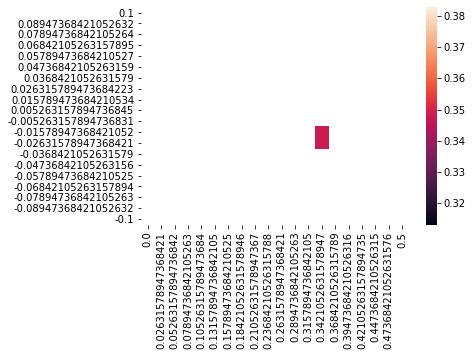

In [52]:
xx = pd.DataFrame(index=phis, columns=thetas)
for poss in possibilities:
    xx.at[poss[0], poss[1]] = difference[poss]

for col in thetas:
    xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

sns.heatmap(xx)

In [31]:
len([k for (k,v) in difference.items() if v < thresh])

162

## Scaling possibility simulation difference by exponential

[2.89894942e-04 6.54050727e-04 1.64392878e-03 4.33469630e-03
 1.16489608e-02 3.15311929e-02 8.55767033e-02 2.32487632e-01
 6.31832940e-01]


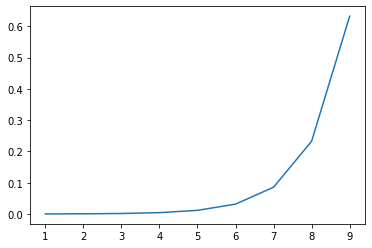

In [45]:




import matplotlib.pyplot as plt
yy = [monoExp(x, 1, 1, 1) for x in range(1, 10)]
plt.plot(np.arange(1,10), yy/sum(yy))
#plt.plot(np.arange(1,10), [monoExp(x, 1, 1, 1) for x in range(1,10)])
print(yy/sum(yy))

In [ ]:
difference = {possib: monoExp(np.linalg.norm(cf_outcomes[possib][:t] - game.ret[:t]), 1, 1, ) for possib in possibilities}


# How cause

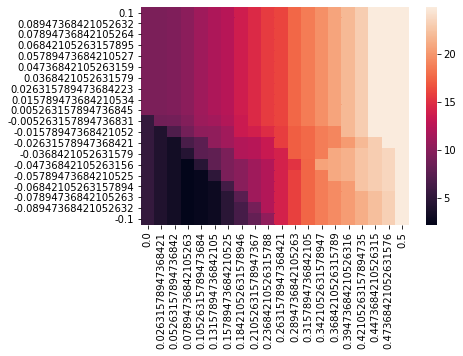

In [16]:
sns.heatmap(xx)

In [13]:
xx.dtypes

0.000000    object
0.026316    object
0.052632    object
0.078947    object
0.105263    object
0.131579    object
0.157895    object
0.184211    object
0.210526    object
0.236842    object
0.263158    object
0.289474    object
0.315789    object
0.342105    object
0.368421    object
0.394737    object
0.421053    object
0.447368    object
0.473684    object
0.500000    object
dtype: object

In [50]:
game.ret[:2]

0     7
1    14
Name: ret, dtype: int64